# 1. Library

In [31]:
path_to_base_package = '../..'
import sys
# setting path
sys.path.append(f'{path_to_base_package}')
import mne
mne.viz.set_3d_backend('notebook')

import json
from sklearn.preprocessing import StandardScaler

import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mna.utils.data_access import *
from mna.utils.analysis import *
from mne.datasets import fetch_fsaverage
from mne import SourceEstimate

import pickle

In [2]:
output_dir = f'{path_to_base_package}/output/saved_files/pickle_files/corrected_voice_timestamp'
output_dir_non_baseline_non_average = f"{output_dir}/saved_files_non_baseline_non_average/" # saved files directory (trial or motor)

exposure_epochs = get_exposure_epochs(f"{path_to_base_package}/output/exposure/exposure_epochs.pickle")

Adding metadata with 5 columns
509 matching events found
No baseline correction applied


In [3]:
with open(f'{output_dir}/ica_epochs.pickle', 'rb') as handle:
    ica_proc_epochs = pickle.load(handle)
    
all_epochs = mne.concatenate_epochs(list(ica_proc_epochs.values()))
all_epochs = mne.concatenate_epochs([all_epochs['hard'],all_epochs['easy']])

# get EEG data and labels from concatenated epoch objects
proc_epochs_data = all_epochs.get_data()
proc_labels = all_epochs.events[:,2]

Adding metadata with 63 columns
1895 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Adding metadata with 63 columns
990 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)


In [4]:
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
'''
select the boundary element model, note that the source data has been downsampled by a factor of 5 
(i.e. ico == 5, https://mne.tools/stable/generated/mne.setup_source_space.html#mne.setup_source_space)
and the BEM has been downsampled by a factor of 5 (i.e. ico == 4, see here: https://mne.tools/stable/generated/mne.make_bem_model.html)
implications here: https://brainder.org/2016/05/31/downsampling-decimating-a-brain-surface/
'''
src_fname = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

eeg_montage='biosemi64'
info = all_epochs.info

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage(eeg_montage)

# Check that the locations of EEG electrodes is correct with respect to MRI
#mne.viz.plot_alignment(
#    info, src=src_fname, eeg=['original', 'projected'], trans=trans,
#    show_axes=False, mri_fiducials=True, dig='fiducials')
fwd = mne.make_forward_solution(info, trans=trans, src=src_fname,
                                bem=bem, eeg=True, n_jobs=None)

0 files missing from root.txt in /home/jiali/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/jiali/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /opt/conda/envs/mna/lib/python3.10/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 8742.8 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 5349.6 ms

Setting up for EEG...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s finished


Computing rank from data with rank=None


/tmp/ipykernel_9709/2464554218.py:4: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(exposure_epochs, method='auto') # note this is not average referenced


    Using tolerance 6.1e-07 (2.2e-16 eps * 64 dim * 4.3e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 326269
log-likelihood on unseen data (descending order):
   shrunk: -706.964
   diagonal_fixed: -794.575
   empirical: -338786.930
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 64 dim * 1.7e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors


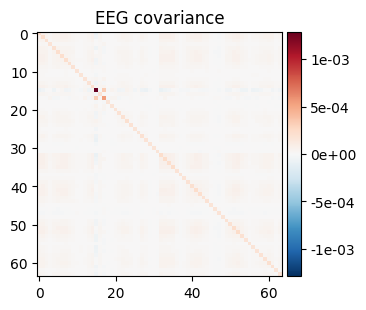

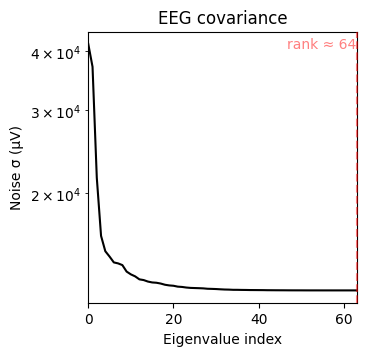

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.329337
    scale = 108975 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 64 dim * 1.5e+07  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD

In [5]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
cov = mne.compute_covariance(exposure_epochs, method='auto') # note this is not average referenced
cov.plot(exposure_epochs.info)
inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd, cov)
#low_motor = get_forward_results(output_dir, 'low',low_motor_sensor,inverse_operator,fwd, lambda2)
#high_motor = get_forward_results(output_dir, 'high',high_motor_sensor,inverse_operator,fwd, lambda2)

In [6]:
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package)

Reading labels from parcellation...
   read 82 labels from /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot


In [19]:
epochs_easy = all_epochs['easy'].average()
epochs_hard = all_epochs['hard'].average()

In [26]:
easy_source_estimate = mne.minimum_norm.apply_inverse(epochs_easy, inverse_operator, lambda2=1.0 / snr ** 2, verbose=False,
                                        method="eLORETA", pick_ori="normal")

In [27]:
easy_source_estimate.get_peak(hemi='lh')

(1007, 0.4296875)

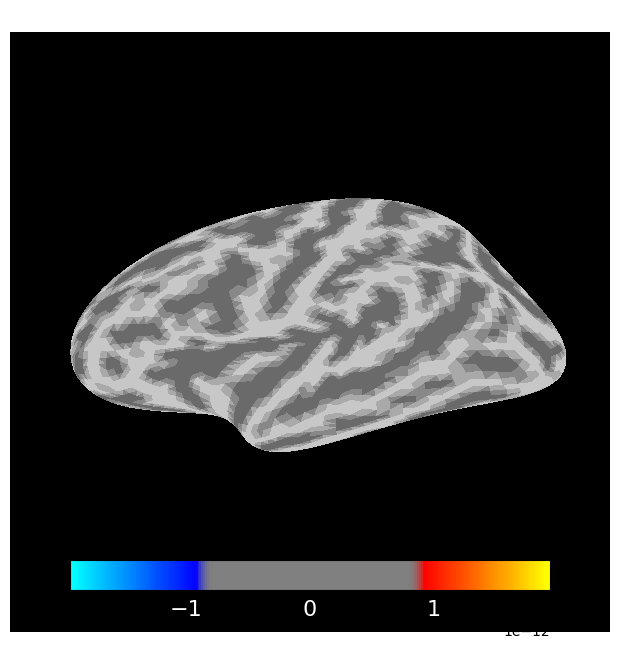

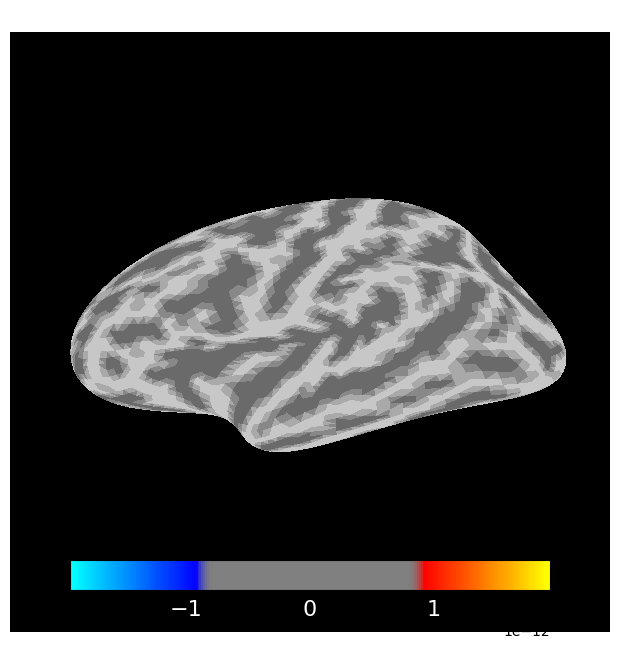

In [29]:
easy_source_estimate.plot(hemi = 'lh', initial_time=3, backend='matplotlib', smoothing_steps = 50, verbose = False)

In [33]:
time_interval = np.arange(0.0, 3.1, 0.1)

stc_plot = [easy_source_estimate.plot(hemi = 'lh', initial_time=t_init, smoothing_steps = 30, verbose = False) 
            for t_init in time_interval]
    

RuntimeError: Using the notebook backend on Linux requires a compatible VTK setup. Consider using Xfvb or xvfb-run to set up a working virtual display, or install VTK with OSMesa enabled.

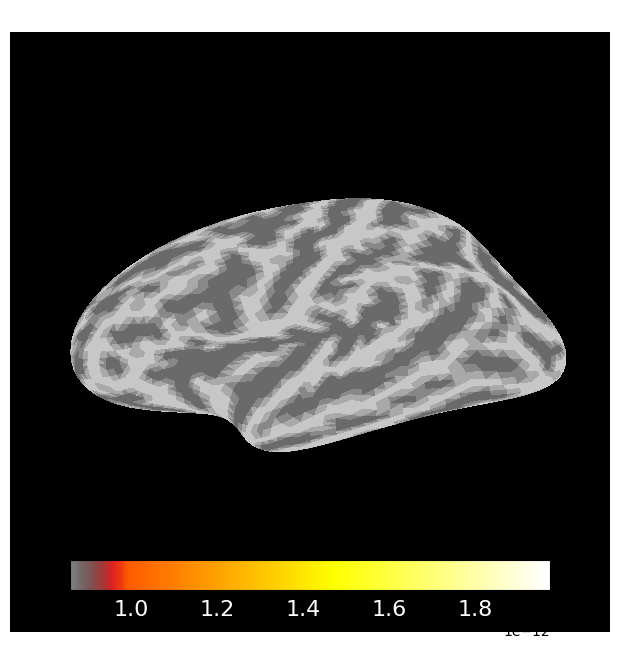

In [8]:
def get_all_tcs(output_dir, overwrite=False):
    if not overwrite and os.path.isfile(f"{output_dir}source_time_courses.pickle"):
        all_tcs = pickle.load(open(f"{output_dir}source_time_courses.pickle", 'rb'))
        return np.concatenate(all_tcs)
    else:
        bin_size = 500 # number of sources to compute in batch
        mode = 'mean'
        count = 0
        all_tcs=[]
        while count*bin_size <= len(all_epochs):
            print('bin',count)
            stcs = mne.minimum_norm.apply_inverse_epochs(all_epochs[count*bin_size:(count+1)*bin_size], inverse_operator,
                                        lambda2=1.0 / snr ** 2, verbose=False,
                                        method="eLORETA") # , pick_ori="normal"?
            tcs = mne.extract_label_time_course(stcs, rel_labels, src=fwd['src'], mode=mode,verbose=False)
            all_tcs.append(tcs)
            count += 1
        # plot the last time course
        plot_source_time_course(ltc=tcs[0], orig_stc=stcs[0], label=rel_labels[0], mode = 'mean',rel_mappings=rel_mappings)
        with open(f"{output_dir}source_time_courses.pickle", 'wb') as handle_tcs:
            pickle.dump(all_tcs, handle_tcs, protocol=pickle.HIGHEST_PROTOCOL)

        with open(f'{output_dir}source_estimate.pickle','wb') as handle_source_estimate:
            pickle.dump(stcs, handle_source_estimate, protocol=pickle.HIGHEST_PROTOCOL)

    return np.concatenate(all_tcs), stcs

bin 0
bin 1


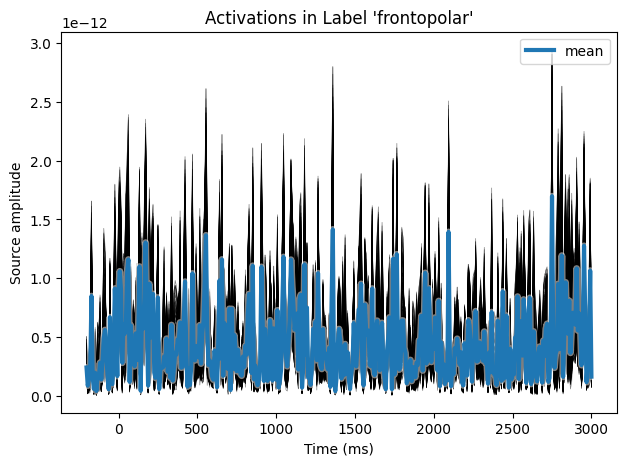

In [10]:
all_tcs, stcs = get_all_tcs(output_dir_non_baseline_non_average, overwrite=True)
assert len(all_tcs) == len(all_epochs), 'the source data is not the same size as the motor_epochs, check this issue'

In [63]:
# rel_mappings
lh_vertices = [rel_labels[i].vertices for i in range(len(rel_labels)) if rel_labels[i].hemi == 'lh']
rh_vertices = [rel_labels[i].vertices for i in range(len(rel_labels)) if rel_labels[i].hemi == 'rh']
vertices_list = [lh_vertices[0], rh_vertices[0]]

Using control points [6.21557900e-13 8.14081903e-13 2.49158239e-12]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


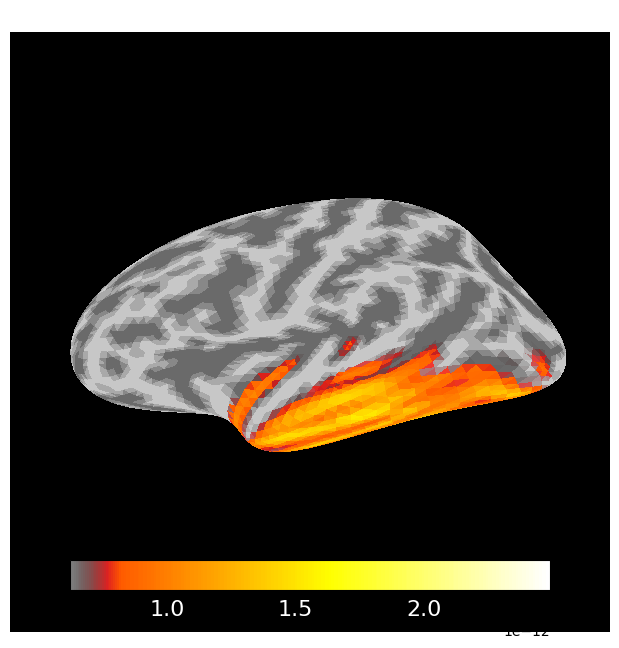

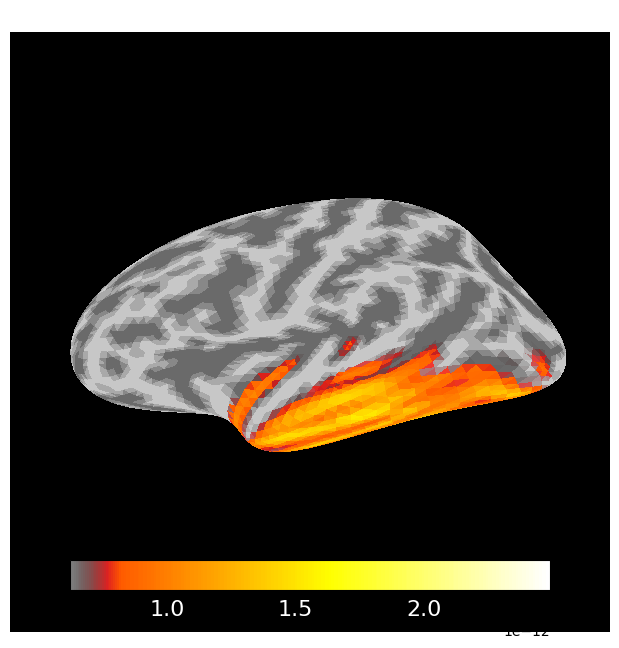

In [116]:
stcs_test[7].plot(hemi = 'lh', backend = 'matplotlib')

In [65]:
avg_tcs = np.mean(all_tcs, axis = 0)

brain = SourceEstimate(Brodmann_10_stc, vertices_list, 0, 0.5)

ValueError: kernel ((26, 411)) and sens_data ((26, 411)) have invalid dimensions

In [20]:
avg_tcs.shape

(26, 411)